In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from scipy.io import readsav


import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Selecting HIP 104214 from the list of perfect targets (p14) and seeing what I can find. Fun Friday afternoon project.

In [2]:
# path = '/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-104214/'

In [3]:
# iuespecs = glob.glob('{}iue/*vo.fits'.format(path))
# iuespecs

In [4]:
# fig, ax = plt.subplots()

# for spec in iuespecs:
#     data = fits.getdata(spec, 1)[0]
#     w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']
#     ax.step(w[dq==0],f[dq==0], where='mid')
#     # ax.step(w,e, where='mid')
    

Seems like it's going the wrong way?Ah- it's the wrong star! MAST box too big. Try agian with a different one!  HIP 108870 = eps ind has loads of IUE data!

In [27]:
path = '/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-108870/'

In [6]:
iuespecs = glob.glob('{}iue/*vo.fits'.format(path))
# iuespecs

(1e-15, 6.56231097207592e-10)

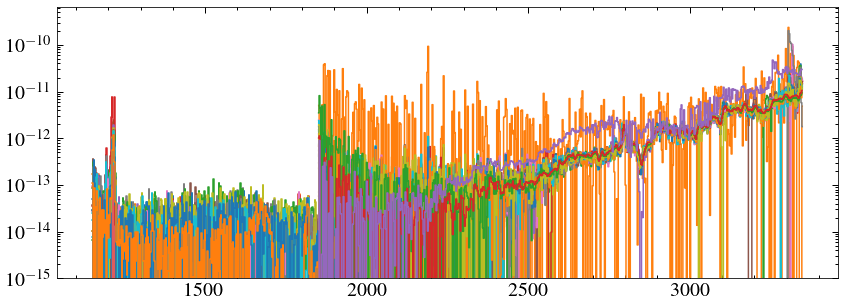

In [7]:
fig, ax = plt.subplots()

for spec in iuespecs:
    data = fits.getdata(spec, 1)[0]
    w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']
    # ax.step(w[dq==0],f[dq==0], where='mid')
    ax.step(w,f, where='mid')
    
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylim(1e-15)


One of these is not like the others? Fixed, MAST does not clear the download basket once you've finished with it. Good to know. Some potenitally interesting flux calibration fun there. lwr14068mxlo_vo.fits is a wavecal? Fixed. Something up with lwr10686mxlo_vo.fits.

In [28]:
stisspecs = glob.glob('{}hst/*x1d.fits'.format(path))
stisspecs

['/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-108870/hst/ob4501010_x1d.fits']

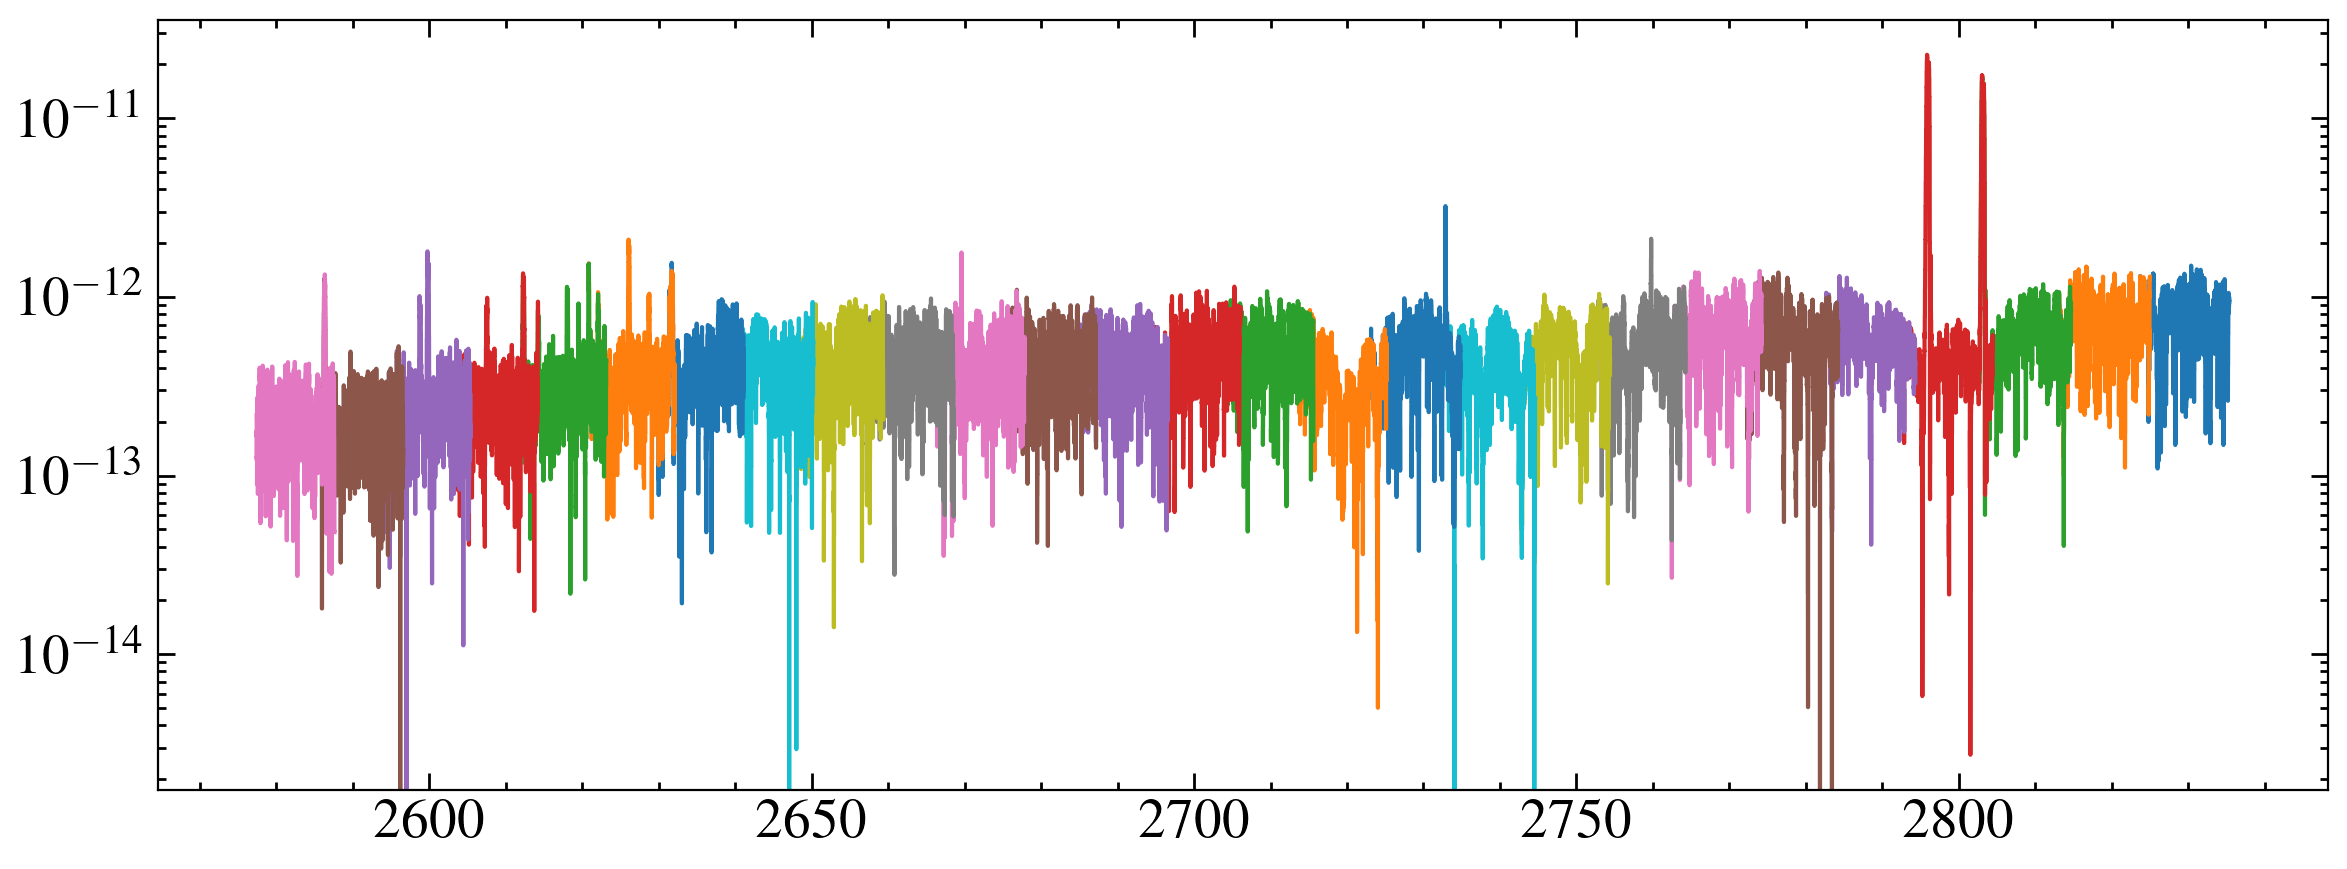

In [29]:
fig, ax = plt.subplots()

for spec in stisspecs:
    alldata = fits.getdata(spec, 1)
    for data in alldata:
        w, f, e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
        ax.step(w[dq==0],f[dq==0], where='mid')
ax.set_yscale('log')


Need to writre a script that extracts GHRS files. For now:

FileNotFoundError: [Errno 2] No such file or directory: '/media/david/2tb_ext_hd/hddata/hwo/data/iue/hst/z2h00108t_c0f.fits'

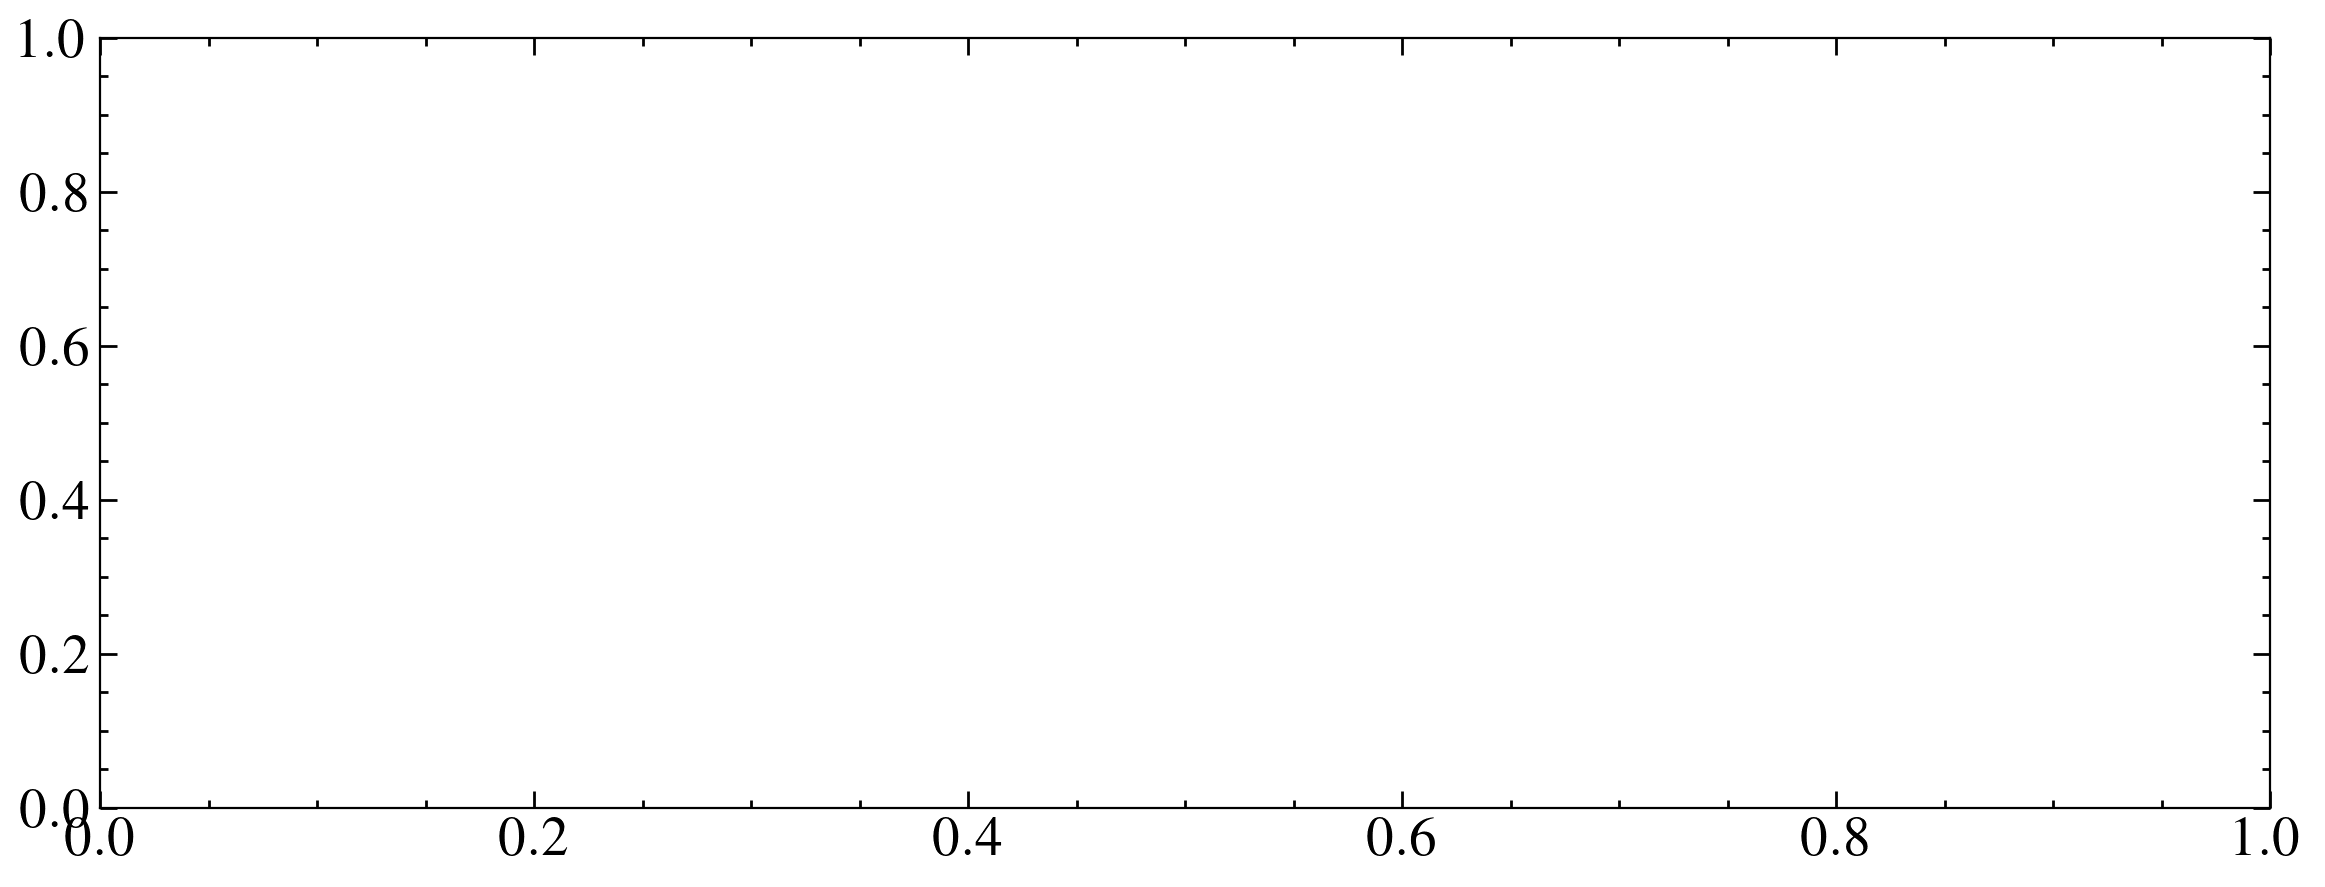

In [23]:

ghrsroots = ['z2h00108t', 'z2h00308m']
for root in ghrsroots:
    fig, ax = plt.subplots()

    wg = fits.getdata('{}hst/{}_c0f.fits'.format(path, root), 0)
    fg = fits.getdata('{}hst/{}_c1f.fits'.format(path, root), 0)
    eg = fits.getdata('{}hst/{}_c2f.fits'.format(path, root), 0)

    ax.step(w, f, where='mid')
    ax.step(w, e, where='mid')

    plt.show()
        
        

Nicely resolved Lya line, wonder what happned to the other ob? Looks like a failed extraction. No, failed observation! Think that's it for the UV. Next steps- X-ray, and filter/coadd uv data.

<!-- Looking at E140M data of HD20630 to see if we could get a good lya spectrum from it. -->

In [3]:
# path = '/media/david/2tb_ext_hd/hddata/hwo/data/hst/HD20630/'
# x1ds = glob.glob('{}*x1d.fits'.format(path))
# x1ds

['/media/david/2tb_ext_hd/hddata/hwo/data/hst/HD20630/o5bn03050_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/hwo/data/hst/HD20630/o5bn03060_x1d.fits']

In [9]:
# for x in x1ds[0:1]:
#     dt = fits.getdata(x, 1)
#     for data in dt:
#         mask = (data['WAVELENGTH'] > 1160)
#         plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])
#     plt.xlim(1210, 1220)


Made an apec model based on the ROSAT count rate and pimms

In [10]:
from  xspec import *


Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            1.00000      frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000      +/-  0.0          
________________________________________________________________________

fluxnum: 0.0

Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      0.250000     +/-  0.0          
   2    1   apec       Abundanc            0.400000     frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.53700E-03  +/-  0.0          
   5    2   phabs      nH         10^22    1.00000E-04  +/-  0.0

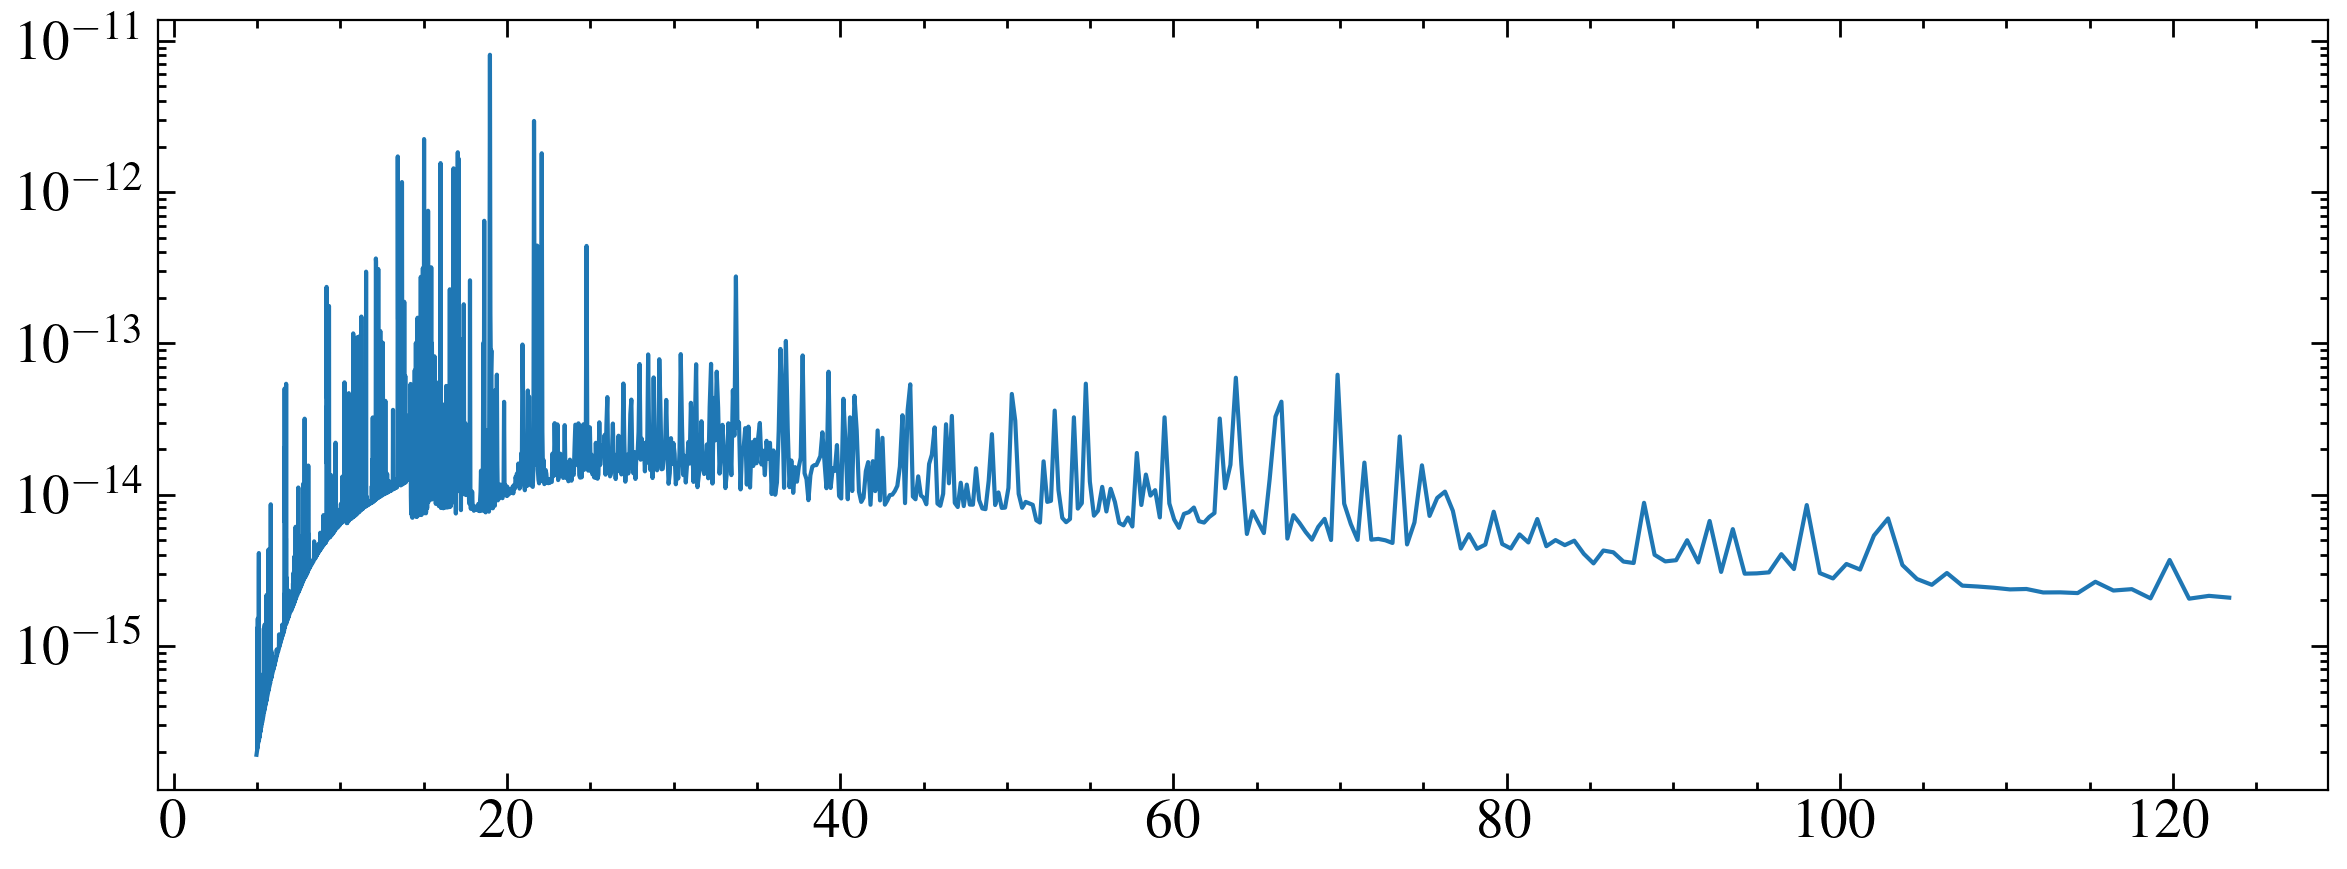

In [13]:
mod = Model('apec*phabs', setPars={1:0.25, 2:0.4, 4:1.537E-03, 5:1e-4})
Plot.xAxis = "angstrom"
Plot.perHz = False
Plot.area=True

AllModels.setEnergies("0.1 2.5 2400")
fluxnum = mod.flux[0]
print('fluxnum:', fluxnum)
Plot("model")
xVals = Plot.x()
yVals = Plot.model()
wx = xVals*u.AA
fx  = (yVals * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
plt.plot(wx, fx)
# plt.xlim(5, 50)
plt.yscale('log')
fitplt.show()

In [16]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

In [31]:
import stis_echelle_splice 

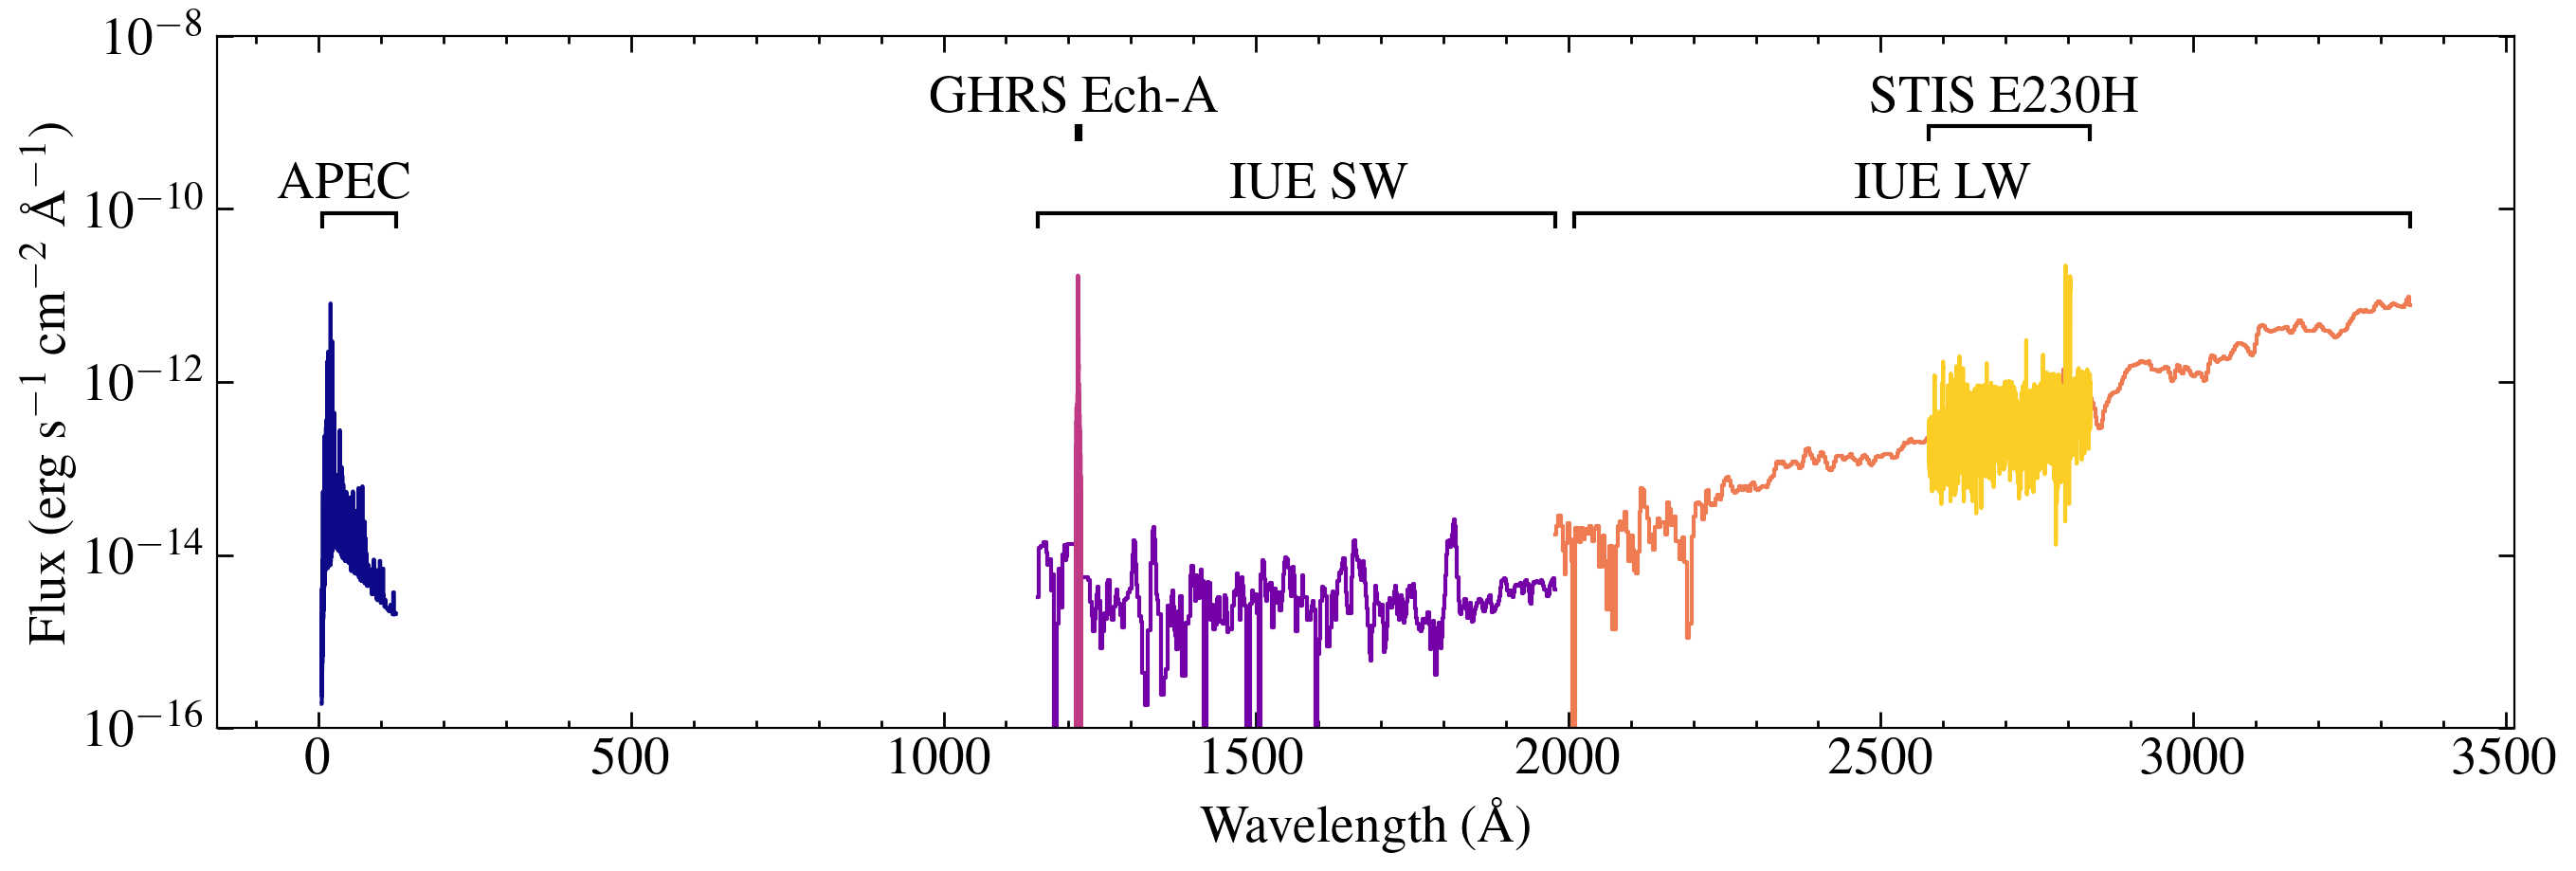

In [72]:
fig, ax = plt.subplots()

path = '/media/david/2tb_ext_hd/hddata/hwo/data/iue/'
star = 'HIP_108870'
iuespecs = glob.glob('{}{}/*vo.fits'.format(path, star))

    
sw_f = []
sw_e = []
lw_f = []
lw_e = []
n = 0
o = 0
for spec in iuespecs:
    data = fits.getdata(spec, 1)[0]
    w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']

    if os.path.split(spec)[1][0:2] == 'sw':
        if n == 0:
            w_sw = w
            sw_f.append(f)
            sw_e.append(e)
        else:
            fi = interp1d(w, f, fill_value='extrapolate')(w_sw)
            ei = interp1d(w, e, fill_value='extrapolate')(w_sw)
            sw_f.append(fi)
            sw_e.append(ei)
        n += 1
    if os.path.split(spec)[1][0:2] == 'lw':
        if o == 0:
            w_lw = w
            lw_f.append(f)
            lw_e.append(e)
        else:
            fi = interp1d(w, f, fill_value='extrapolate')(w_lw)
            ei = interp1d(w, e, fill_value='extrapolate')(w_lw)
            lw_f.append(fi)
            lw_e.append(ei)
        o += 1

# print(lwr_e)
f_lw, e_lw = spectra_adder(np.array(lw_f), np.array(lw_e))
f_sw, e_sw = spectra_adder(np.array(sw_f), np.array(sw_e))


        # ax.step(w[dq==0],f[dq==0], where='mid')
        # ax.step(w,f, where='mid')

smask = (f_sw > 0) & (w < 1200) | (f_sw > 0) & (w > 1230) #& (w_swp < w_lw[0])
lmask = (f_lw > 0) & (w_lw >= w_sw[-1])

f_sw = convolve(f_sw,Box1DKernel(2))
f_lw = convolve(f_lw,Box1DKernel(2))
# e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)



# norm = 1/f_lw[-1]
#ghrs 
gdata = fits.getdata('ghrs_test_fits/hd209100-2_hrs_ech-a_z2h00308m.fits', 1)
wg, fg = gdata['WAVELENGTH'], gdata['FLUX']
fg = convolve(fg,Box1DKernel(2))





#x-ray



#stisnuv
data = fits.getdata('/media/david/2tb_ext_hd/hddata/hwo/data/hst/HIP-108870/ob4501010_x1d.fits', 1)
wi, fi, ei, dqi = stis_echelle_splice.echelle_coadd_dq(data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ'], nclip=10, find_ratio=False)
fi = convolve(fi,Box1DKernel(2))


cols = np.linspace(0, 0.9, 5)

ax.step(wx, fx, where='mid', c= plt.cm.plasma(cols[0]) )
ax.step(w_sw[smask], (f_sw[smask]), where='mid', c= plt.cm.plasma(cols[1]))
ax.step(wg, fg, where='mid', c= plt.cm.plasma(cols[2]))

ax.step(w_lw[lmask], (f_lw[lmask]), where='mid', c= plt.cm.plasma(cols[3]))

ax.step(wi[dqi==0], fi[dqi==0], where='mid', c= plt.cm.plasma(cols[4]))

liney = 9e-11
lineb = 3e-11
linescale = 1.5

plt.errorbar(np.array([wi[0], wi[-1]]),np.array([liney*10, liney*10]),yerr=np.array([[lineb*10, lineb*10], [0.,0]]), c='k')
plt.errorbar(np.array([wg[0], wg[-1]]),np.array([liney*10, liney*10]),yerr=np.array([[lineb*10, lineb*10], [0.,0]]), c='k')
plt.errorbar(np.array([w_sw[0], w_sw[-1]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
plt.errorbar(np.array([w_lw[lmask][0]+30, w_lw[lmask][-1]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
# plt.errorbar(np.array([ow[(ow > nw[-1])][0]+50, pwi[0]]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
plt.errorbar(np.array([wx[0].value, wx[-1].value]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')
# plt.errorbar(np.array([10, 1900]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')

# plt.errorbar(np.array([pwi[0]+200, 120000.]),np.array([liney, liney]),yerr=np.array([[lineb, lineb], [0.,0]]), c='k')

plt.annotate('APEC', (40, liney*linescale, ), ha='center')
plt.annotate('IUE SW', (1600, liney*linescale, ), ha='center')
plt.annotate('IUE LW', (2600, liney*linescale, ), ha='center')
plt.annotate('STIS E230H', (2700, liney*10*linescale, ), ha='center')
plt.annotate('GHRS Ech-A', (1210, liney*10*linescale, ), ha='center')
# plt.annotate('HST', (3300, liney*linescale, ), ha='center')
# plt.annotate('Solar proxy', (200, liney*linescale, ), ha='center')
# plt.annotate('PHOENIX', (28000, liney*linescale, ), ha='center')



ax.set_ylim(1e-16, 1e-8)
ax.set_yscale('log')
# ax.axvline(w_sw[-1], ls='--', c='0.5' )
# ax.annotate(r'SW*', (1500, 3e10))
# ax.annotate(r'LW*', (2600, 3e10))
# ax.set_xscale('log')
    # ax.set_ylim(1e-15)
ax.set_xlabel('Wavelength (\AA)')
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# ax.set_ylim(5e-5 , 6e10)

fig.tight_layout()